<a href="https://colab.research.google.com/github/rageh-ai/janeStreetComp/blob/main/janeStreetComp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Setting Up

A few administrative tasks like connecting to the kaggle API, downloading the kaggle library and making necessary imports.

In [ ]:
! pip install -q kaggle
! pip install dask[dataframe]

In [4]:
from google.colab import files
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.feature_selection import mutual_info_regression # For continuous target
import dask.dataframe as dd

In [ ]:
files.upload()

In [5]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [6]:
! kaggle competitions download -c jane-street-real-time-market-data-forecasting

100% 11.5G/11.5G [02:01<00:00, 144MB/s]
100% 11.5G/11.5G [02:01<00:00, 101MB/s]


In [7]:
! unzip jane-street-real-time-market-data-forecasting.zip

Archive:  jane-street-real-time-market-data-forecasting.zip
  inflating: features.csv            
  inflating: kaggle_evaluation/__init__.py  
  inflating: kaggle_evaluation/core/__init__.py  
  inflating: kaggle_evaluation/core/base_gateway.py  
  inflating: kaggle_evaluation/core/generated/__init__.py  
  inflating: kaggle_evaluation/core/generated/kaggle_evaluation_pb2.py  
  inflating: kaggle_evaluation/core/generated/kaggle_evaluation_pb2_grpc.py  
  inflating: kaggle_evaluation/core/kaggle_evaluation.proto  
  inflating: kaggle_evaluation/core/relay.py  
  inflating: kaggle_evaluation/core/templates.py  
  inflating: kaggle_evaluation/jane_street_gateway.py  
  inflating: kaggle_evaluation/jane_street_inference_server.py  
  inflating: lags.parquet/date_id=0/part-0.parquet  
  inflating: responders.csv          
  inflating: sample_submission.csv   
  inflating: test.parquet/date_id=0/part-0.parquet  
  inflating: train.parquet/partition_id=0/part-0.parquet  
  inflating: train.p

In [8]:
! ls

features.csv					   lags.parquet		  test.parquet
jane-street-real-time-market-data-forecasting.zip  responders.csv	  train.parquet
kaggle_evaluation				   sample_data
kaggle.json					   sample_submission.csv


# Data Loading and Preprocessing

In [12]:
partitionIds = [0,1,2]
parquetFiles = [f'train.parquet/partition_id={i}/part-{0}.parquet' for i in partitionIds]
dfs = []

for f in parquetFiles:
  print(f)
  df = dd.read_parquet(f, compression='gzip')
  dfs.append(df)

train = dd.concat(dfs, ignore_index=True)


train.parquet/partition_id=0/part-0.parquet
train.parquet/partition_id=1/part-0.parquet
train.parquet/partition_id=2/part-0.parquet


In [13]:
train.head()

date_id  time_id  symbol_id    weight  feature_00  feature_01  feature_02  \
0        0        0          1  3.889038         NaN         NaN         NaN   
1        0        0          7  1.370613         NaN         NaN         NaN   
2        0        0          9  2.285698         NaN         NaN         NaN   
3        0        0         10  0.690606         NaN         NaN         NaN   
4        0        0         14  0.440570         NaN         NaN         NaN   

   feature_03  feature_04  feature_05  ...  responder_0  responder_1  \
0         NaN         NaN    0.851033  ...     0.738489    -0.069556   
1         NaN         NaN    0.676961  ...     2.965889     1.190077   
2         NaN         NaN    1.056285  ...    -0.864488    -0.280303   
3         NaN         NaN    1.139366  ...     0.408499     0.223992   
4         NaN         NaN    0.955200  ...    -0.373387    -0.502764   

   responder_2  responder_3  responder_4  responder_5  responder_6  \
0     1.380875     2.005353     0.186018     1.218368     0.775981   
1    -0.523998     3.849921     2.626981     5.000000     0.703665   
2    -0.326697     0.375781     1.271291     0.099793     2.109352   
3     2.294888     1.097444     1.225872     1.225376     1.114137   
4    -0.348021    -3.928148    -1.591366    -5.000000    -3.572820   

   responder_7  responder_8  partition_id  
0     0.346999     0.095504             0  
1     0.216683     0.778639             0  
2     0.670881     0.772828             0  
3     0.775199    -1.379516             0  
4    -1.089123    -5.000000             0  

[5 rows x 93 columns]

## Missing Value Analysis

In [14]:
null_counts = train.isnull().sum().compute()
filtered_null_counts = null_counts[null_counts != 0]
print(filtered_null_counts)

feature_00    3182052
feature_01    3182052
feature_02    3182052
feature_03    3182052
feature_04    3182052
feature_08      16980
feature_15     220141
feature_16        127
feature_17      36835
feature_18        108
feature_19        108
feature_21    7785330
feature_26    7785330
feature_27    7785330
feature_31    7785330
feature_32      86944
feature_33      86944
feature_39    1218228
feature_40      60513
feature_41     302823
feature_42    1218228
feature_43      60513
feature_44     302823
feature_45     285782
feature_46     285782
feature_47         87
feature_50    1173760
feature_51       9170
feature_52     256760
feature_53    1173760
feature_54       9170
feature_55     256760
feature_56        108
feature_57        108
feature_58      86939
feature_62     265893
feature_63     215147
feature_64     222975
feature_65     285782
feature_66     285782
feature_73      86939
feature_74      86939
feature_75        254
feature_76        254
dtype: int64


#Exploratory Analysis

I am going to start looking at the data, some of the features, and much more.

In [5]:
train.head()

date_id  time_id  symbol_id    weight  feature_00  feature_01  feature_02  \
0      850        0          0  2.087724   -0.276877   -2.385324   -1.086325   
1      850        0          1  3.752097   -0.168178   -2.161023   -0.511679   
2      850        0          2  1.225099   -0.520426   -1.718115   -0.817358   
3      850        0          3  1.467042   -0.061985   -1.818735   -0.990254   
4      850        0          5  3.144071   -0.321442   -1.964041   -0.409452   

   feature_03  feature_04  feature_05  ...  feature_78  responder_0  \
0    0.049463    3.427029   -4.671824  ...   -0.295312    -0.346724   
1    0.192425    3.162096   -4.386098  ...   -0.444008    -0.086088   
2   -0.270528    3.314825   -2.578923  ...   -0.267447     0.636380   
3    0.274284    3.810929   -1.111770  ...   -0.157564     2.754708   
4   -0.343893    3.069664   -2.929145  ...   -0.138634     0.151213   

   responder_1  responder_2  responder_3  responder_4  responder_5  \
0     0.054874    -0.050004     0.803933     0.725200     0.141694   
1     0.056619    -0.396622     0.396958     1.208221    -1.016843   
2     0.280909     1.168953    -2.395850    -1.057062    -3.009765   
3     0.792327     0.403978    -0.096906    -0.263321     0.094231   
4     0.207094     0.139006    -0.440090     0.145323    -0.967585   

   responder_6  responder_7  responder_8  
0     1.461546     0.779843     0.404129  
1     0.789595     1.251492    -1.701416  
2    -2.848316    -0.974728    -5.000000  
3    -0.749164    -0.691085    -0.089415  
4    -0.882600     0.131690    -1.548052  

[5 rows x 92 columns]

In [11]:
train.describe().compute()

KeyboardInterrupt: 

## Analyzing Time Series of All Features

I plan to analyze how the each of the features differ over the course of the days seen in the data. I will look at the mean, median, and std, grouped by day.

In [7]:


feature_cols = [col for col in train.columns if col.startswith('feature')]

# Group data by date
grouped = train.groupby('date_id')

# Calculate statistics
stats = grouped[feature_cols].agg(['std', 'mean', 'median'])
stats.head()

feature_00                     feature_01                      \
               std      mean    median        std      mean    median   
date_id                                                                 
850       0.349082 -0.881684 -0.895240   1.172027  0.127786  0.185160   
851       0.326890 -1.314619 -1.315460   1.057694  0.090760  0.002547   
852       0.319097 -1.767275 -1.769961   1.148343 -0.272418 -0.105113   
853       0.360203 -1.053298 -1.076519   1.128270  0.299521  0.224749   
854       0.337441 -1.424506 -1.433008   1.127711  0.272295  0.426104   

        feature_02                     feature_03  ... feature_75 feature_76  \
               std      mean    median        std  ...     median        std   
date_id                                            ...                         
850       0.333988 -0.935288 -0.942893   0.350021  ...  -0.251742   0.477851   
851       0.352002 -1.322218 -1.322450   0.350544  ...  -0.245772   0.563258   
852       0.361099 -1.746930 -1.761668   0.349579  ...  -0.242594   0.499538   
853       0.319472 -1.139149 -1.137515   0.330284  ...  -0.239644   0.609137   
854       0.318338 -1.472850 -1.471981   0.325083  ...  -0.235049   0.616550   

                            feature_77                     feature_78  \
             mean    median        std      mean    median        std   
date_id                                                                 
850     -0.246134 -0.296423   0.469578 -0.210725 -0.250896   0.465580   
851     -0.138521 -0.229360   0.507317 -0.171448 -0.241477   0.487099   
852     -0.181492 -0.264078   0.410792 -0.169429 -0.232460   0.415658   
853     -0.135801 -0.245516   0.615319 -0.128841 -0.234763   0.609492   
854     -0.125879 -0.272141   0.608507 -0.083785 -0.220885   0.607893   

                             
             mean    median  
date_id                      
850     -0.260887 -0.298373  
851     -0.159037 -0.221939  
852     -0.201538 -0.259540  
853     -0.150287 -0.240590  
854     -0.141135 -0.254569  

[5 rows x 237 columns]

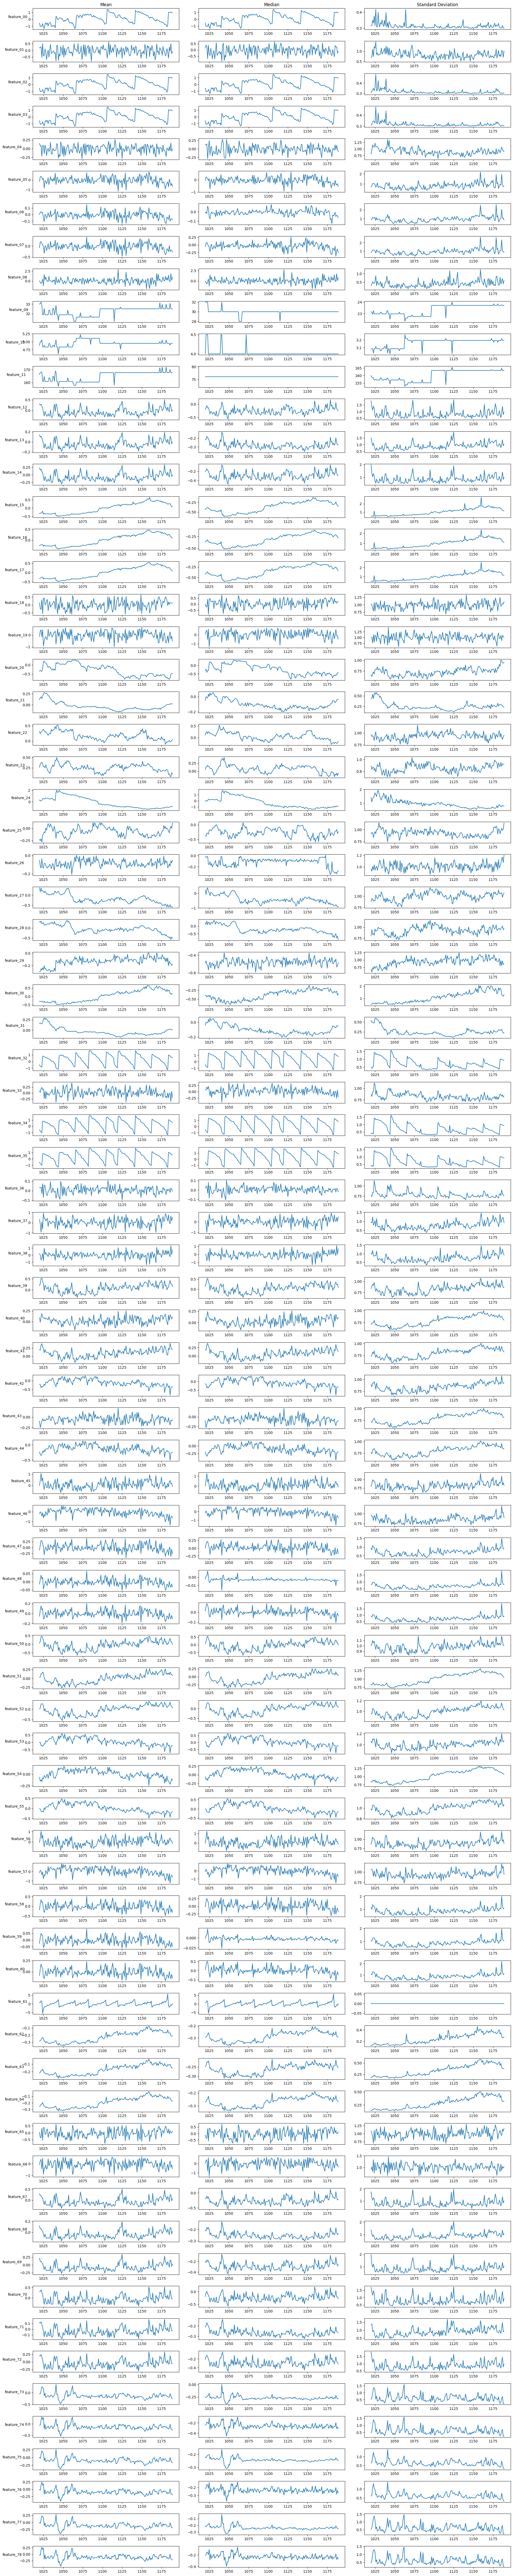

In [ ]:
## std, mean, and median for each of the features across all days

fig, ax = plt.subplots(len(feature_cols), 3, figsize=(20, 100), dpi=100)

for i,col in enumerate(feature_cols):
  ax[i][0].plot(stats.index, stats[col]['mean'])
  ax[i][1].plot(stats.index, stats[col]['median'])
  ax[i][2].plot(stats.index, stats[col]['std'])

  ax[i][0].set_ylabel(col, rotation=0, labelpad=20)


ax[0, 0].set_title("Mean")
ax[0, 1].set_title("Median")
ax[0, 2].set_title("Standard Deviation")

fig.tight_layout()
plt.savefig(f'partition-{partitionIds[0]}-featureStatistics.png')
plt.show()

- Seeing what seems to be a lot of corelated features
- Seeing seasonality

## Corelation Between Features
Analyzing how various features are corelated to each other.


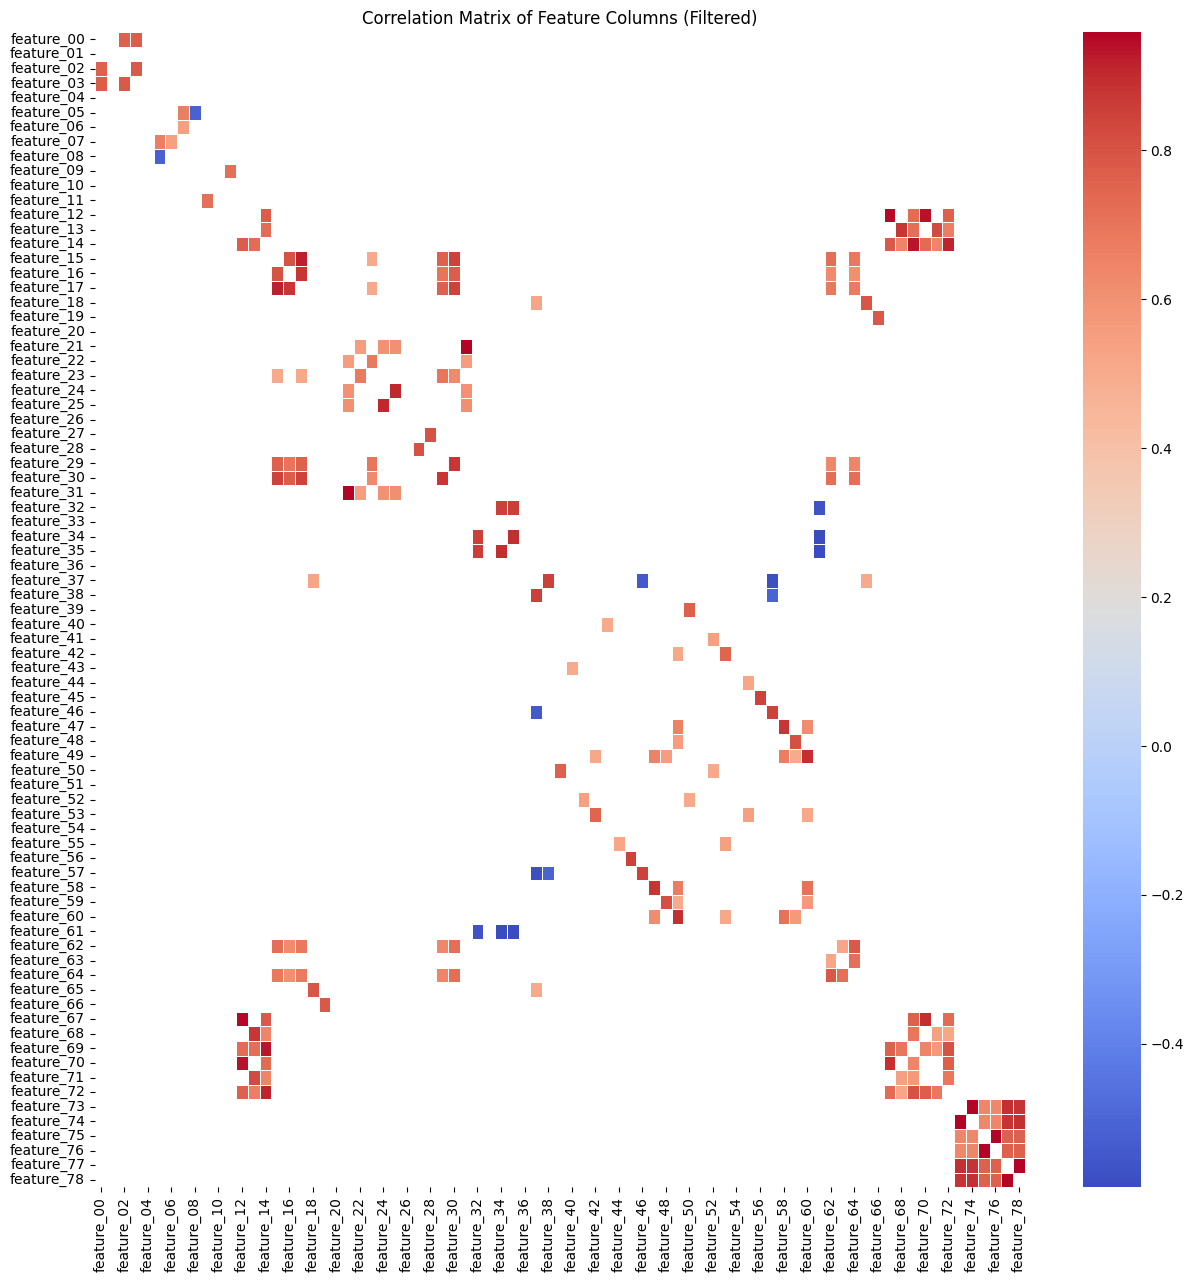

In [8]:
# prompt: fill nan values in the corelation matrix with 0

# ... (Your existing code for data loading and preprocessing) ...

# Calculate the correlation matrix
correlation_matrix = train[feature_cols].corr()

# Fill NaN values with 0
correlation_matrix = correlation_matrix.fillna(0)

# Filter for correlations greater than 0.5
filtered_correlation = correlation_matrix[abs(correlation_matrix) > 0.5]

# Remove same feature correlations (diagonal)
filtered_correlation = filtered_correlation.mask(np.equal(*np.indices(filtered_correlation.shape)))

plt.figure(figsize=(15, 15))
sns.heatmap(filtered_correlation, annot=False, cmap='coolwarm', fmt=".2f", linewidths=.5) # Added linewidths for separation
plt.title('Correlation Matrix of Feature Columns (Filtered)')
plt.show()

In [17]:
high_corr_features = set()
filtered_correlation= filtered_correlation[abs(filtered_correlation) > 0.5]
filtered_correlation.head()

for x in filtered_correlation.columns:
  for y in filtered_correlation.index:
    if x != y and (y,x) not in high_corr_features and abs(filtered_correlation.loc[y,x] >= 0.5):
      high_corr_features.add((x,y))
print('Corelated Features')
for corr in high_corr_features:
  print(corr)


Corelated Features
('feature_22', 'feature_23')
('feature_16', 'feature_30')
('feature_13', 'feature_69')
('feature_45', 'feature_56')
('feature_67', 'feature_70')
('feature_30', 'feature_62')
('feature_58', 'feature_60')
('feature_69', 'feature_72')
('feature_42', 'feature_49')
('feature_29', 'feature_30')
('feature_21', 'feature_31')
('feature_74', 'feature_76')
('feature_75', 'feature_76')
('feature_13', 'feature_71')
('feature_13', 'feature_14')
('feature_17', 'feature_64')
('feature_12', 'feature_67')
('feature_09', 'feature_11')
('feature_21', 'feature_25')
('feature_14', 'feature_70')
('feature_47', 'feature_58')
('feature_17', 'feature_62')
('feature_24', 'feature_31')
('feature_70', 'feature_72')
('feature_16', 'feature_64')
('feature_73', 'feature_76')
('feature_24', 'feature_25')
('feature_47', 'feature_60')
('feature_16', 'feature_62')
('feature_14', 'feature_69')
('feature_48', 'feature_49')
('feature_34', 'feature_35')
('feature_15', 'feature_30')
('feature_18', 'feature_

## Corelation Between Features and Target Variables

How do the features relate to the target variable?


In [20]:
# Assuming 'train' is your DataFrame with features and target
# 'target_variable' is the name of your target column
# 'feature_cols' is the list of your feature columns

correlations = train[feature_cols + ['responder_6']].corr()
target_correlations = correlations['responder_6']

# Print or visualize the correlations
print(target_correlations)
# or
# import seaborn as sns
# sns.heatmap(correlations, annot=True, cmap='coolwarm')

feature_00     0.014090
feature_01    -0.006315
feature_02     0.017553
feature_03     0.014769
feature_04    -0.031852
                 ...   
feature_75     0.000626
feature_76     0.001904
feature_77     0.003361
feature_78     0.004146
responder_6    1.000000
Name: responder_6, Length: 80, dtype: float64


No significant corelations

In [28]:
# Example using mutual_info_regression
mi_scores = mutual_info_regression(train[feature_cols], train['responder_6'])
mi_scores = pd.Series(mi_scores, name="MI Scores", index=feature_cols)
mi_scores = mi_scores.sort_values(ascending=False)
print(mi_scores)

ValueError: Input X contains NaN.

## Corelation Between Responders

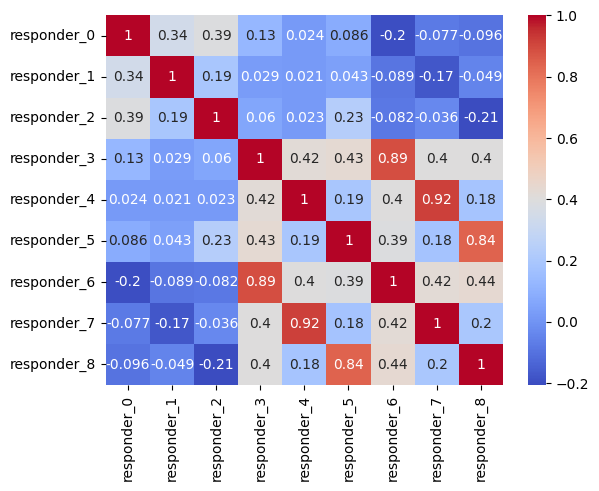

In [36]:
responder_cols = [col for col in train.columns if col.startswith('responder')]
sns.heatmap(train[responder_cols].corr(), annot=True, cmap='coolwarm')
plt.show()

Responder 3 -> Responder 6 <br>
Responder 4 -> Responder 7 <br>
Responder 5 -> Responder <br>
<br>
These responders are highly corelated